# Cross-Asset Volatility Arbitrage Engine

This notebook implements a volatility arbitrage strategy for GLD/GDX, replicating the pipeline from `run.py` with interactive visualizations.

In [2]:
import os
os.chdir(r'C:\Users\yvonn\cross-asset-volatility-arbitrage-engine')
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\yvonn\cross-asset-volatility-arbitrage-engine


In [3]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import load_data
from src.volatility import realized_vol
from src.signals import calculate_spread, generate_signals
from src.optimizer import optimize_portfolio
from src.backtest import backtest
%matplotlib inline

# Configuration
tickers = ['GLD', 'GDX']
start_date = '2015-01-01'

In [4]:
# Load data
prices = load_data(tickers, start_date)
if prices is None:
    raise Exception('Failed to load data')

Loaded cached data from data/prices.csv


In [5]:
# Calculate volatility
vol_gld = realized_vol(prices['GLD'])
vol_gdx = realized_vol(prices['GDX'])

In [6]:
# Calculate spread and signals
z_score = calculate_spread(vol_gld, vol_gdx)
signals = generate_signals(z_score)

C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\signals.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if z_score[i] > entry_threshold:
C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\signals.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif z_score[i] < -entry_threshold:
C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\signals.py:20: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  si

In [7]:
# Optimize portfolio
returns = prices.pct_change().dropna()
weights = optimize_portfolio(returns, signals)

C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\optimizer.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals[t] != 0:
C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\optimizer.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals[t] != 0:
C:\Users\yvonn\cross-asset-volatility-arbitrage-engine\src\optimizer.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signals[t] != 0:
C:\Users\yvon

In [8]:
# Run backtest
backtest_results = backtest(prices, signals, weights)

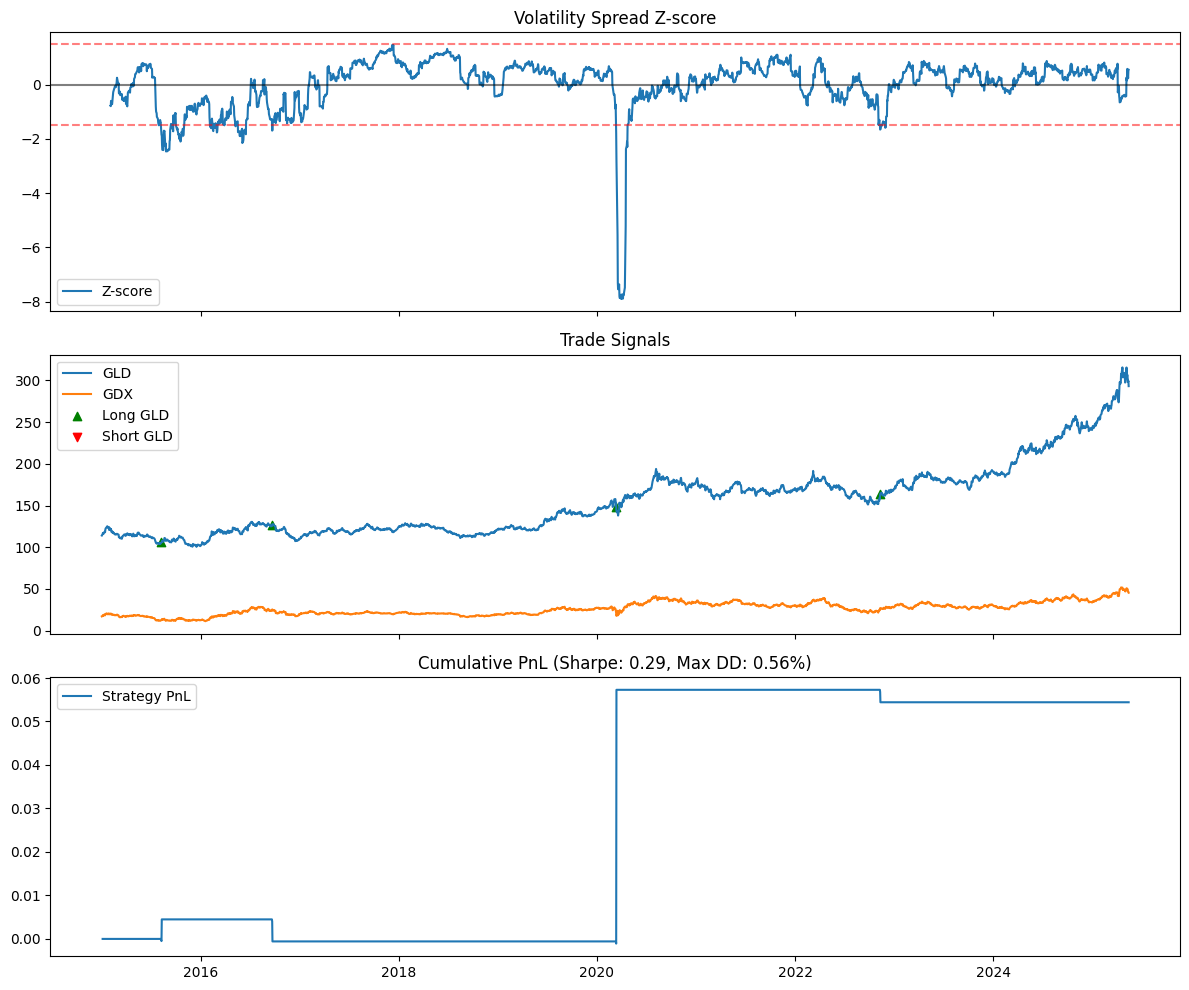

Backtest complete. Results saved to data/performance_summary.csv


C:\Users\yvonn\AppData\Local\Temp\ipykernel_16048\3997238831.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Total Return': backtest_results['cumulative_pnl'][-1]


In [9]:
# Visualize results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Z-score and signals
ax1.plot(z_score, label='Z-score')
ax1.axhline(1.5, color='r', linestyle='--', alpha=0.5)
ax1.axhline(-1.5, color='r', linestyle='--', alpha=0.5)
ax1.axhline(0, color='k', linestyle='-', alpha=0.5)
ax1.set_title('Volatility Spread Z-score')
ax1.legend()

# Trade signals
long_signals = signals[signals == 1].index
short_signals = signals[signals == -1].index
ax2.plot(prices.index, prices['GLD'], label='GLD')
ax2.plot(prices.index, prices['GDX'], label='GDX')
ax2.scatter(long_signals, prices.loc[long_signals, 'GLD'], c='g', marker='^', label='Long GLD')
ax2.scatter(short_signals, prices.loc[short_signals, 'GLD'], c='r', marker='v', label='Short GLD')
ax2.set_title('Trade Signals')
ax2.legend()

# Cumulative PnL
ax3.plot(backtest_results['cumulative_pnl'], label='Strategy PnL')
ax3.set_title(f"Cumulative PnL (Sharpe: {backtest_results['sharpe']:.2f}, Max DD: {backtest_results['max_drawdown']:.2%})")
ax3.legend()

plt.tight_layout()
plt.show()

# Save performance summary
summary = {
    'Sharpe Ratio': backtest_results['sharpe'],
    'Max Drawdown': backtest_results['max_drawdown'],
    'Total Return': backtest_results['cumulative_pnl'][-1]
}
pd.Series(summary).to_csv('data/performance_summary.csv')
print('Backtest complete. Results saved to data/performance_summary.csv')